# Wikipedia requests for adminship (Rfa)

In [1]:
#!pip install d3graph
import pandas as pd
import numpy as np
import networkx as nx
import networkx.algorithms.community as nxc
from networkx.algorithms import community
from networkx.algorithms.community.quality import modularity
import community
from community import community_louvain
from d3graph import d3graph, vec2adjmat
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from collections import Counter
import warnings
from sklearn.preprocessing import StandardScaler
import time

## Story

Context (fictional):
As a data scientist working for a leading AI research organization called "AI Innovations," my organization is at the forefront of developing large-scale neural network models. We recognize that the quality of training data significantly impacts the performance and reliability of these models. One of our key challenges is ensuring the accuracy of the data used for training, especially when it involves incorporating information from external sources like Wikipedia articles. 

To address this, we decide to conduct a network analysis of Wikipedia requests for adminship (Rfa) data to understand the roles and responsibilities of administrators in maintaining data quality. Wikipedia’s quality is maintained by its admins who perform various maintenance tasks. The admins act as custodians of the encyclopedia and its community of contributors. Since certain privileges are granted to this group of users, membership to this group is usually deliberated upon by the community to ensure that a person seeking membership is qualified. In Wikipedia, the requests for adminship (RfA) process is instituted to give regular users administrative privileges.

It is crucial to recognize that the outcomes of the voting process directly impact which users are entrusted with content moderation duties. Therefore, understanding the underlying network of voting patterns becomes vital in determining the composition of the administrator community and the individuals responsible for maintaining the integrity of the data. By analyzing the voting network, we aim to gain insights into the dynamics of trust, influence, and decision-making within the community, which ultimately shape the selection of users who will moderate content on the platform.

Experiment Plan:

* Data Collection and preprocessing, selecting a time period to analyze.
* Graph Construction, convert the dataset into a graph representation, where each user is represented as a node, and the relationships between users are captured as edges.
* Graph Analysis:
a). Compute Graph Properties: analyze various graph properties. These properties will provide insights into the overall structure and characteristics of the network and highlight any potential knowledge gaps or biases within the administration community.
b). Centrality Measures: calculate centrality measures like degree centrality, betweenness centrality, and eigenvector centrality. These measures will help identify influential users who have played significant roles in voting, as well as those who have connections with a wide range of contributors.
c). Node Comparison: compare nodes based on different centrality measures to identify administrators who have demonstrated a strong commitment to voting process.
* Community Discovery:
a. Run Community Detection Algorithms: to identify distinct communities within the network. These algorithms will help uncover clusters of users.
b. Community Analysis: analyze the identified communities by examining their characteristics, such as size, density, and average centrality measures. Identify key users within each community who have actively contributed to ensuring the quality of data used for neural network training.

* Node Role Assignment: assign roles to the nodes in the graph based on their characteristics, centrality measures, and the outcomes of community analysis.

Purpose and Value: The purpose of this experiment is to gain insights into the voting network of Wikipedia RfA. This analysis will help us understand the dynamics of data quality management within the Wikipedia administration community. The value created for the organization will be twofold: improving the selection process for administrators responsible for data quality and enhancing the reliability and accuracy of our neural network models by incorporating high-quality training data. Ultimately, these insights will contribute to the development of more robust and trustworthy AI systems and promote the use of accurate and reliable information from external sources like Wikipedia.

## The Data

Today, Wikipedia.org is the seventh most popular website on the planet. Wikipedia represents huge amount of data, English-language recent Wikipedia dump is around 19GB compressed and expands to over 86 GB when decompressed. And it has evolved into one of the most popular training sets for AI researchers. Almost all LLM intensively used wikipedia datasets for training.

Requests for adminship (RfA) is the process by which the Wikipedia community decides who will become administrators (also known as admins), who are users with access to additional technical features that aid in maintenance. The additional features granted to administrators are considered to require a high level of trust from the community. While administrative actions are publicly logged and can be reverted by other administrators just as other edits can be, the actions of administrators involve features that can affect the entire site. Among other functions, administrators are responsible for blocking users from editing, controlling page protection, and deleting pages.

The community grants administrator access to trusted users, so nominees should have been on Wikipedia long enough for people to determine whether they are trustworthy. Administrators are held to high standards of conduct because other editors often turn to them for help and advice, and because they have access to tools that can have a negative impact on users or content if carelessly applied.

For a Wikipedia editor to become an administrator, a request for adminship (RfA) must be submitted. An RfA begins when a user is nominated to become an admin. After the nomination, the community deliberates on the qualification of the nominee and then finally votes on the eligibility of the candidate for adminship. A voter casts either a support (positive), oppose (negative), or neutral vote. Once the voting period expires, members of a special class of admins called bureaucrats review the results of the voting and conclude with a final decision - whether to promote the nominee or not. A few things that distinguish the Wikipedia RfA from other known elections are: (1) voters can change their votes, (2) an election spans a week on the average, and (3) voters can observe the votes of others.

Consensus at RfA is not determined by surpassing a numerical threshold, but by the strength of rationales presented. In practice, most RfAs above 75% support pass.

The dataset contains 11,381 users (voters and votees) forming 189,004 distinct voter/votee pairs (since the adoption of the RfA process in 2003 through May 2013.), for a total of 198,275 votes (this is larger than the number of distinct voter/votee pairs because, if the same user ran for election several times, the same voter/votee pair may contribute several votes).

This induces a directed, signed network in which nodes represent Wikipedia members and edges represent votes. 

Data format is a txt file with following rows:
* SRC: user name of source, i.e., voter
* TGT: user name of target, i.e., the user running for election
* VOT: the source's vote on the target (-1 = oppose; 0 = neutral; 1 = support)
* RES: the outcome of the election (-1 = target was rejected as admin; 1 = target was accepted)
* YEA: the year in which the election was started
* DAT: the date and time of this vote
* TXT: the comment written by the source, in wiki markup

In our analysis, we will reduce the original dataset: we will analyze only 2012 (the most recent year with the full dataset), only positive votes (VOT = 1), and only those votes on which positive decisions were made (RES = 1)

Sources: Robert West, Hristo S. Paskov, Jure Leskovec, and Christopher Potts: Exploiting Social Network Structure for Person-to-Person Sentiment Analysis. Transactions of the Association for Computational Linguistics, 2(Oct):297–310, 2014.

Link for downloading: https://snap.stanford.edu/data/wiki-RfA.html

In [2]:
start_time = time.time()

Reading the 'wiki-Rfa.txt' file and creating an initial dataframe table:

In [3]:
df_data = []

with open('wiki-RfA.txt', 'r', encoding='cp437') as file:
    entries = file.read().split('\n\n')  # Split entries based on double line breaks
    
    for entry in entries:
        entry_dict = {'Source': None, 'Target': None, 'Vote': None, 'Result': None, 'Year': None, 'Date': None, 'Comment': None}
        
        lines = entry.split('\n')
        
        for line in lines:
            if line.startswith('SRC:'):
                entry_dict['Source'] = line.split('SRC:')[1]
            elif line.startswith('TGT:'):
                entry_dict['Target'] = line.split('TGT:')[1]
            elif line.startswith('VOT:'):
                entry_dict['Vote'] = int(line.split('VOT:')[1])
            elif line.startswith('RES:'):
                entry_dict['Result'] = int(line.split('RES:')[1])
            elif line.startswith('YEA:'):
                entry_dict['Year'] = line.split('YEA:')[1]
            elif line.startswith('DAT:'):
                entry_dict['Date'] = line.split('DAT:')[1]
            elif line.startswith('TXT:'):
                entry_dict['Comment'] = line.split('TXT:')[1]
        
        df_data.append(entry_dict)

df_data = pd.DataFrame.from_records(df_data)

In [4]:
print(df_data.shape)
df_data.head(5)

(198276, 7)


,Source,Target,Vote,Result,Year,Date,Comment
0,Steel1943,BDD,1.0,1.0,2013,"23:13, 19 April 2013",'''Support''' as co-nom.
1,Cuchullain,BDD,1.0,1.0,2013,"01:04, 20 April 2013",'''Support''' as nominator.--
2,INeverCry,BDD,1.0,1.0,2013,"23:43, 19 April 2013",'''Support''' per noms.
3,Cncmaster,BDD,1.0,1.0,2013,"00:11, 20 April 2013",'''Support''' per noms. BDD is a strong contri...
4,Miniapolis,BDD,1.0,1.0,2013,"00:56, 20 April 2013","'''Support''', with great pleasure. I work wit..."


There are 198 276 rows in the dataset: each row is one vote from Source user to the Target user.

Let's look at the distribution of votes (1 - positive, 0 - neutral, -1 - negative):

In [5]:
pd.DataFrame(df_data['Vote'].value_counts(normalize=True))

,proportion
Vote,
1.0,0.728539
-1.0,0.207671
0.0,0.063790


Can see that almost 73% of the votes are positive, 21% are negative and 6% are neutral

The results of the votes:

In [6]:
pd.DataFrame(df_data['Result'].value_counts(normalize=True))

,proportion
Result,
1.0,0.621803
-1.0,0.378197


Most of the vote results are positive

Distribution of the votes during the years:

In [7]:
pd.DataFrame([round(df_data['Year'].value_counts(normalize=True), 3), df_data['Year'].value_counts()]).sort_index()

Year,2006,2007,2008,2009,2005,2010,2011,2004,2012,2013,2003
count,45325.000,41541.00,30479.000,21375.000,20239.000,13970.00,8556.000,6541.000,6474.000,3572.000,203.000
proportion,0.229,0.21,0.154,0.108,0.102,0.07,0.043,0.033,0.033,0.018,0.001


You can observe a decrease in the number of votes for the period. The most active year was 2006 with over 45,000 votes. Our attention is drawn to the year 2012. We are interested only in 2012 year - the most recent one and with data for the whole year. In the future we will analyze only this year's data

In [8]:
df_2012 = df_data[df_data['Year'] == '2012']

Let's look at the distribution of votes and results:

In [9]:
pd.DataFrame(df_2012['Result'].value_counts(normalize=True))

,proportion
Result,
1.0,0.505406
-1.0,0.494594


In [10]:
pd.DataFrame(df_2012['Vote'].value_counts(normalize=True))

,proportion
Vote,
1.0,0.673154
-1.0,0.263825
0.0,0.063021


Half of the votes were with positive (1) and half with the negative (-1) results. And more than 67% of votes were positive. In future analyses we need only positive votes. Also we do not need columns 'Date' and 'Comment' for our analyses.

In [11]:
df_2012 = df_2012[df_2012['Result'] == 1.0]
df_2012 = df_2012[df_2012['Vote'] == 1.0]
df_2012 = df_2012.drop(columns=['Date', 'Comment'])
df_2012.shape

(2948, 5)

As a result, our dataset consists of 2948 rows of votes

In [12]:
df_2012.describe(include='object')

,Source,Target,Year
count,2948,2948,2948
unique,756,28,1
top,Tryptofish,SarahStierch,2012
freq,25,217,2948


756 unique users voted for 28 unique applicants

In [13]:
df_2012.head()

,Source,Target,Vote,Result,Year
3572,AutomaticStrikeout,Bagumba,1.0,1.0,2012
3573,Kurtis,Bagumba,1.0,1.0,2012
3574,Zagalejo,Bagumba,1.0,1.0,2012
3575,Wizardman,Bagumba,1.0,1.0,2012
3576,Ched,Bagumba,1.0,1.0,2012


Top 5 the most active voters:

In [14]:
pd.DataFrame(df_2012['Source'].value_counts(normalize=True)).head(5)

,proportion
Source,
Tryptofish,0.008480
Lord Roem,0.008480
Secret,0.007802
RP459,0.007802
Stephen,0.007463


The applpicants with more positive votes:

In [15]:
pd.DataFrame(df_2012['Target'].value_counts(normalize=True)).head()

,proportion
Target,
SarahStierch,0.073609
Berean Hunter,0.054274
Bbb23,0.045794
Dennis Brown,0.045455
KTC,0.044098


## IDA

Creating a diracted graph:

In [16]:
G = nx.from_pandas_edgelist(df_2012, source='Source', target='Target', edge_attr='Vote', create_using=nx.DiGraph)

In [17]:
G.order(), G.size()

(762, 2948)

We have a directed graph with 762 nodes (one for each user) and 2948 edges (votes)

Calculate the degree dictribution:

In [18]:
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
degree_count = nx.degree_histogram(G) #Returns a list of the frequency of each degree value.

degree_dist = []
for degree, count in enumerate(degree_count):
    degree_dist.append({'Degree': degree, 'Number of nodes': count})

df_degree_dist = pd.DataFrame(degree_dist) #create a DataFrame for the degree distribution
print(df_degree_dist[df_degree_dist['Number of nodes'] != 0].head()) #print the least dense number of nodes
print(df_degree_dist[df_degree_dist['Number of nodes'] != 0].tail()) # print the most dense nodes

   Degree  Number of nodes
1       1              310
2       2              125
3       3               64
4       4               45
5       5               41
     Degree  Number of nodes
143     143                1
146     146                1
152     152                1
168     168                1
221     221                1


485 nodes out of 762 (77%) have not more than 5 degrees. Also there are some nodes with more than 150 degrees

Plotting the degree distribution:

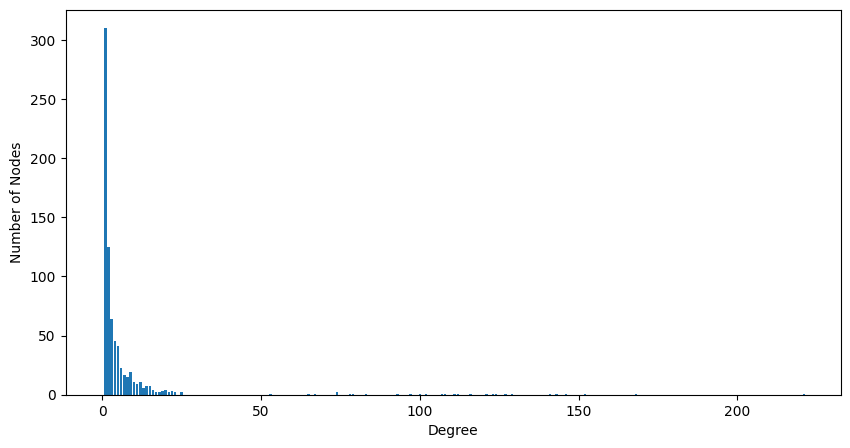

In [19]:
plt.figure(figsize=(10, 5))
plt.bar(range(len(degree_count)), degree_count)
plt.xlabel('Degree')
plt.ylabel('Number of Nodes')
plt.show()

The vast majority of nodes have a low degree

Visualizing the graph:

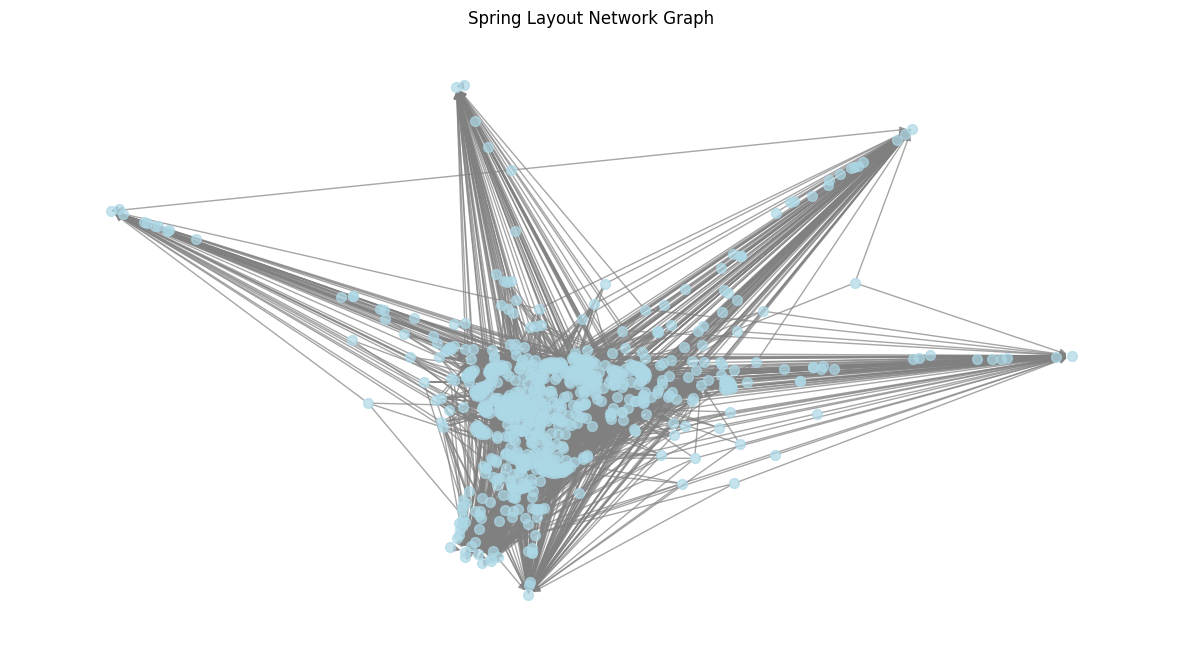

In [20]:
plt.figure(figsize=(15, 8))
pos = nx.spring_layout(G, seed=1) #Position nodes using Fruchterman-Reingold force-directed algorithm
nx.draw_networkx(G, pos=pos, with_labels=False, node_color='lightblue', node_size=50, font_size=10, alpha=0.7, edge_color='grey')
plt.title("Spring Layout Network Graph")
plt.axis('off')
plt.show()

We can see that a large number of nodes are concentrated in the center, from which the edges are directed to the nodes that are at a distance. We can assume that the nodes in the center are the voting nodes, and the nodes on the periphery, to which the edges (votes) approach, are the applicants

And one more graph in 3D. It's more readable.

In [21]:
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning) #Ignoring warnings
source = df_2012.Source
target = df_2012.Target
adjmat = vec2adjmat(source, target)
d3 = d3graph(charge=4000, collision=0.3) #Higher charge makes edges longer
d3.graph(adjmat)
d3.show(show_slider=False, title='RfA Network Graph', click=({'fill': 'red', 'stroke': 'black', 'size': 1.3, 'stroke-width': 3}))
warnings.filterwarnings('default', category=pd.errors.PerformanceWarning) #Returning warnings

[d3graph] INFO> Set directed=True to see the markers!
[d3graph] INFO> Keep only edges with weight>0
[d3graph] INFO> Number of unique nodes: 761
[d3graph] INFO> Slider range is set to [0, 1]
[d3graph] INFO> Write to path: [C:\Users\lenovo\AppData\Local\Temp\tmpl5v83f4i\d3graph.html]
[d3graph] INFO> File already exists and will be overwritten: [C:\Users\lenovo\AppData\Local\Temp\tmpl5v83f4i\d3graph.html]


On the interactive graphics in 3d you can better see the nodes with a stronger degree. Unlike the previous chart, in this one the applicants nodes are concentrated in the center. Also we can use search (ctrl+F) to find nodes we want. But it is not possible to highlight any patterns or draw any conclusions. For this it is necessary to carry out a further analysis 

Top 5 nodes with maximum in-degree. These are the applicants who received the most votes

In [22]:
pd.DataFrame(G.in_degree).sort_values(by=1, ascending=False).head()

,0,1
221,SarahStierch,217
86,Berean Hunter,160
65,Bbb23,135
9,Dennis Brown,134
282,KTC,130


Top 5 nodes with maximum out-degree. These are users who voted the most:

In [23]:
pd.DataFrame(G.out_degree).sort_values(by=1, ascending=False).head()

,0,1
122,Lord Roem,25
34,Tryptofish,25
55,Secret,23
21,RP459,23
42,Newyorkbrad,22


## Graph Properties

Computing graph properties is essential for understanding and analyzing the structure and characteristics of a graph. 

1) Density describes the share of actual edges out of the possible edges. Density is a measure of how connected or dense the graph is, providing insights into the level of interconnectedness between nodes.

In [24]:
nx.density(G)

0.005083792909591951

In a directed graph, each edge has a specific direction, meaning it goes from one node (the source) to another node (the target). A density value of 0.00508 means that only a small fraction of the possible edges are present in the graph. It suggests that the graph is relatively sparse, with fewer connections compared to the total number of potential connections.

2) Connectedness. In digraphs, we have two notions of connectedness: weakly connected (treat the directed edges as undirected
and apply the connectedness definitions of undirected simple graphs and strongly connected (a sub-digraph is called strongly
connected if between any two vertices  a path exists)

In [25]:
for C in nx.weakly_connected_components(G):
    type(C)
    print(len(C))

762


A connected component in a graph refers to a subset of nodes where each node is connected to at least one other node in the same subset. In other words, it is a group of nodes that are all reachable from each other through a path of edges.

Our 762 result means that all 762 nodes in the graph are part of the same connected component. This implies that there is a path between any pair of nodes in the graph, either directly or indirectly through intermediate nodes.

In practical terms, having a single connected component indicates that the graph is fully connected, and any node can reach any other node in the graph by following the directed edges. It suggests a high level of connectivity and indicates that the graph is not fragmented into separate disconnected portions.

The number of nodes which are strongly connected:

In [26]:
len(max(nx.strongly_connected_components(G), key=len))

20

These nodes are:

In [27]:
max(nx.strongly_connected_components(G), key=len)

{'Basalisk',
 'Bbb23',
 'Berean Hunter',
 'Bgwhite',
 'Crisco 1492',
 'Dennis Brown',
 'Dpmuk',
 'GiantSnowman',
 'ItsZippy',
 'Jenks24',
 'KTC',
 'Mark Arsten',
 'MikeLynch',
 'Monty845',
 'Mr. Stradivarius',
 'SarahStierch',
 'Scottywong',
 'Writ Keeper',
 'Yngvadottir',
 'Yunshui'}

Our graph is weakly connected directed graph. Since it is not strongly connected, so we are not able to compute the average shortest path length and diameter (the longest shortest path)

3) Graph Cores show us the densest regions in a graph


In [28]:
G.remove_edges_from(nx.selfloop_edges(G)) #check and clean the self loops
G.order()

762

No self loops

Compute a maximal subgraph with maximum edges (degree). For directed graphs the node degree is defined to be the in-degree + out-degree.

In [29]:
for i in range(10,30):
    if (i%10==0):
        core=nx.k_core(G,i)
        print(i, core.size(), core.order())

10 1263 103
20 0 0


In [30]:
for i in range(10,18):
    core=nx.k_core(G,i)
    print(i, core.size(), core.order())

10 1263 103
11 1153 92
12 1054 83
13 922 72
14 844 66
15 719 57
16 571 47
17 0 0


In [31]:
nx.k_core(G, 16).nodes

NodeView(('Mark Arsten', 'Sergecross73', 'Ponyo', 'TommyBoy', 'Bbb23', 'De728631', 'Bgwhite', 'Kiefer.Wolfowitz', 'Carrite', 'Crisco 1492', 'Ktr101', 'Hahc21', 'Jenks24', 'Zagalejo', 'Tryptofish', 'Scottywong', 'KTC', 'RP459', 'Monty845', 'Harrias', 'GiantSnowman', 'SarahStierch', 'GabeMc', 'ItsZippy', 'Writ Keeper', 'Berean Hunter', 'Secret', 'Boing! said Zebedee', 'Mr. Stradivarius', 'Yunshui', 'Torreslfchero', 'Dank', 'AutomaticStrikeout', 'Basalisk', 'Pharaoh of the Wizards', 'Joe Decker', 'Kudpung', 'Morning Sunshine', 'Brookie', 'Ekabhishek', 'MikeLynch', 'Newyorkbrad', 'Dennis Brown', 'Axl', 'Stephen', 'Lord Roem', 'Bagumba'))

4) Clustering

Compute graph transitivity, the fraction of all possible triangles present in G. Possible triangles are identified by the number of “triads” (two edges with a shared vertex).

In [32]:
nx.transitivity(G)

0.2554132614373578

Transitivity is a measure of how interconnected or clustered a graph is. A transitivity coefficient ranges from 0 to 1, where 0 indicates no transitivity or clustering, and 1 indicates maximum transitivity or complete clustering. The value of 0.255 suggests a moderate level of clustering or interconnectedness within the graph G. The value of 0.255 indicates that approximately 25% of the connected triples in the graph form triangles. In other words, if two nodes in the graph are connected, there is a 25% chance that they are also connected indirectly through a third node. This moderate level of transitivity suggests that there is some clustering within the graph, but it is not highly interconnected

Compute the average clustering coefficient for the graph G:

In [33]:
nx.average_clustering(G)

0.16699017241354855

The average clustering coefficient is another measure of the level of clustering or interconnectedness in a graph. The value of 0.167 suggests a relatively low average clustering coefficient. This means that, on average, the nodes in the graph G have a lower tendency to form clusters or triangles compared to a highly clustered graph. It implies that the graph G may exhibit a more dispersed or random structure rather than a highly interconnected one. 

It's worth noting that the transitivity coefficient and average clustering coefficient are related measures, but they are not always identical. The transitivity coefficient is calculated based on the ratio of triangles to connected triples, while the average clustering coefficient considers the clustering around individual nodes in the graph. Transitivity is a macro average, while the average clustering coefficient is a micro average. Transitivity is strongly influenced by high-degree nodes, while average clustering weights all nodes the same. To have a comprehensive understanding, further analysis of the graph's specific structure and relationships would be necessary.

5) Reciprocity. Reciprocity is a measure of the likelihood that if one node is connected to another node, then there is an edge in the opposite direction

In [34]:
nx.reciprocity(G)

0.02103120759837178

A reciprocity value between 0 and 1 is typically expressed as a percentage. In this case, the reciprocity of 0.021 suggests that only approximately 2.10% of the edges in the graph G form reciprocated connections.

This low reciprocity value indicates a relatively weak tendency for bidirectional connections in the graph. It suggests that when a node is connected to another node, it is less likely for the reverse connection to exist. In other words, there are fewer instances where two nodes mutually connect each other compared to unidirectional connections.

Conclusions after graph properties exploring:

* 762 nodes and 2948 edges.
* Weakly connected. The graph G is weakly connected, meaning there is a directed path from any node to any other node when considering the direction of edges. However, it does not necessarily mean that there is a direct path in both directions between every pair of nodes.
* The largest strongly connected component in G consists of 20 nodes. A strongly connected component is a subset of nodes in a directed graph where there is a directed path from any node to any other node within the subset.
* The transitivity coefficient of the graph G is 0.255, a moderate level of clustering or interconnectedness within the graph.
* The average clustering coefficient of the graph G is 0.167, a relatively low average clustering coefficient, suggesting that, on average, the nodes in the graph have a lower tendency to form clusters or triangles compared to a highly clustered graph.
* The reciprocity of the graph G is 0.021, which indicates a low reciprocity, suggesting a weak tendency for bidirectional connections in the graph. It implies that when a node is connected to another node, it is less likely for the reverse connection to exist.

## Central Nodes

1) HITS algorithm

The nx.hits function in NetworkX performs the HITS (Hypertext Induced Topic Selection) algorithm on the graph to identify hubs and authorities. HITS is an algorithm used for ranking web pages and can also be applied to other types of networks. The function nx.hits returns two dictionaries: hubs and authorities. Each dictionary assigns a score to every node in the graph, representing their respective hubness and authority. Let's compute HITS for the nodes from our graph

In [35]:
hubs, authorities = nx.hits(G)# Compute hubs and authorities
scores_df = pd.DataFrame({'Node': list(hubs.keys()),
                          'Hub Score': list(hubs.values()),
                          'Authority Score': list(authorities.values())})
scores_df['Authority Score'] = scores_df['Authority Score'].apply(lambda x: round(x, 5)) # Set the precision of the authority score column
scores_df['Hub Score Rank'] = scores_df['Hub Score'].rank(ascending=False, method='min')
scores_df['Authority Score Rank'] = scores_df['Authority Score'].rank(ascending=False, method='min')
scores_df.sort_values(by='Hub Score',ascending=False) 

c:\Users\lenovo\python\virtual_environments\data_mining_env\Lib\site-packages\networkx\algorithms\link_analysis\hits_alg.py:78: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G, nodelist=list(G), dtype=float)


,Node,Hub Score,Authority Score,Hub Score Rank,Authority Score Rank
34,Tryptofish,0.008121,0.00000,1.0,29.0
122,Lord Roem,0.007889,-0.00000,2.0,29.0
21,RP459,0.007543,-0.00000,3.0,29.0
42,Newyorkbrad,0.007320,-0.00000,4.0,29.0
46,Carrite,0.007217,0.00000,5.0,29.0
...,...,...,...,...,...
447,Ekabhishek,0.000000,0.02710,757.0,22.0
360,De728631,0.000000,0.03422,757.0,15.0
512,Harrias,0.000000,0.04380,757.0,6.0
708,TommyBoy,0.000000,0.03345,757.0,17.0


Each row in the DataFrame represents a node in the graph, and the columns provide information about that node's hub score and authority score. Hubs are nodes that connect to many authoritative nodes, while authorities are nodes that are linked by many hub nodes. Therefore, high hub scores indicate nodes that are well-connected to other important nodes, and high authority scores indicate nodes that are linked by many influential hub nodes.

In our situation nodes with high hub scores are users who are voting for the admin applicants, nodes with high authority scores

Now we can calculate HITS for nodes from graph core section:

In [36]:
nodes_47 = nx.k_core(G, 16).nodes #Nodes from the core
hubs, authorities = nx.hits(G)  # Calculate HITS scores for the nodes
scores_df = pd.DataFrame({'Node': nodes_47,
                          'Hub Score': [hubs.get(node) for node in nodes_47],
                          'Authority Score': [authorities.get(node) for node in nodes_47]})
scores_df.sort_values(by='Hub Score', ascending=False).head(10)

c:\Users\lenovo\python\virtual_environments\data_mining_env\Lib\site-packages\networkx\algorithms\link_analysis\hits_alg.py:78: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G, nodelist=list(G), dtype=float)


,Node,Hub Score,Authority Score
14,Tryptofish,0.008121,-1.123519e-19
45,Lord Roem,0.007889,-1.037117e-18
17,RP459,0.007543,1.010066e-18
41,Newyorkbrad,0.007320,-1.918445e-19
8,Carrite,0.007217,1.517679e-18
44,Stephen,0.007151,5.206163e-19
37,Morning Sunshine,0.007077,4.710444e-18
28,Mr. Stradivarius,0.007045,4.553324e-02
26,Secret,0.007043,-1.025395e-18
34,Pharaoh of the Wizards,0.006948,7.362872e-19


We can see that nodes from the core have high hub scores. This nodes made the most votes. High hub scores indicate nodes that are well-connected to other important nodes and are the most influential or central nodes in the graph based on the HITS algorithm. 

2) Now we can calculate more node attributes and rankings. The computed node attributes provide different measures of centrality and influence within the graph:

* Out Node Degree: The number of outgoing edges from a node.
* Betweenness Centrality: A measure of the node's importance in facilitating communication between other nodes.
* Closeness Centrality: A measure of how close a node is to all other nodes in the graph.
* In Degree Centrality: The proportion of incoming edges to a node compared to all edges in the graph.
* Out Degree Centrality: The proportion of outgoing edges from a node compared to all edges in the graph.

In [37]:
degrees = dict(G.degree) #total number of degrees (In + Out)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
in_degree_centrality = nx.in_degree_centrality(G)
out_degree_centrality = nx.out_degree_centrality(G)

dataframe = pd.DataFrame({'Node': list(G.nodes()),
                   'Node Degree': list(degrees.values()),
                   'Betweenness Centrality': list(betweenness_centrality.values()),
                   'Closeness Centrality': list(closeness_centrality.values()),
                   'In Degree Centrality': list(in_degree_centrality.values()),
                   'Out Degree Centrality': list(out_degree_centrality.values())})

dataframe['In Degree Centrality Rank'] = dataframe['In Degree Centrality'].rank(ascending=False, method='min')
dataframe['Out Degree Centrality Rank'] = dataframe['Out Degree Centrality'].rank(ascending=False, method='min')
dataframe['Betweenness Centrality Rank'] = dataframe['Betweenness Centrality'].rank(ascending=False, method='min')
dataframe['Closeness Centrality Rank'] = dataframe['Closeness Centrality'].rank(ascending=False, method='min')

dataframe.sort_values(by='Betweenness Centrality Rank', ascending=True).head(5)# Get the top 5 nodes with highest betweenness centrality

,Node,Node Degree,Betweenness Centrality,Closeness Centrality,In Degree Centrality,Out Degree Centrality,In Degree Centrality Rank,Out Degree Centrality Rank,Betweenness Centrality Rank,Closeness Centrality Rank
23,Mr. Stradivarius,146,0.005860,0.425090,0.164258,0.027595,7.0,8.0,1.0,6.0
9,Dennis Brown,152,0.004731,0.407044,0.176084,0.023653,4.0,19.0,2.0,12.0
67,Crisco 1492,124,0.003671,0.382312,0.144547,0.018397,12.0,35.0,3.0,16.0
177,ItsZippy,79,0.003420,0.355116,0.088042,0.015769,25.0,50.0,4.0,21.0
282,KTC,141,0.003366,0.418899,0.170828,0.014455,5.0,62.0,5.0,7.0


Mr. Stradivarius has the highest betweenness centrality rank (1.0), indicating that he plays a crucial role in connecting different parts of the graph. Betweenness centrality measures the extent to which a node lies on the shortest paths between other pairs of nodes in a network. It quantifies the influence or control that a node has over the flow of information or resources between other nodes. This value indicates that the node associated with the highest betweenness centrality has a significant influence on the flow of information or resources between other nodes. In our situation, the node got this position because it most likely participated in the election (received many incoming degrees) and then actively voted itself (provided outgoing degrees). 

We can create a plot to visualize the ego-network of 'Mr. Stradivarius' node:

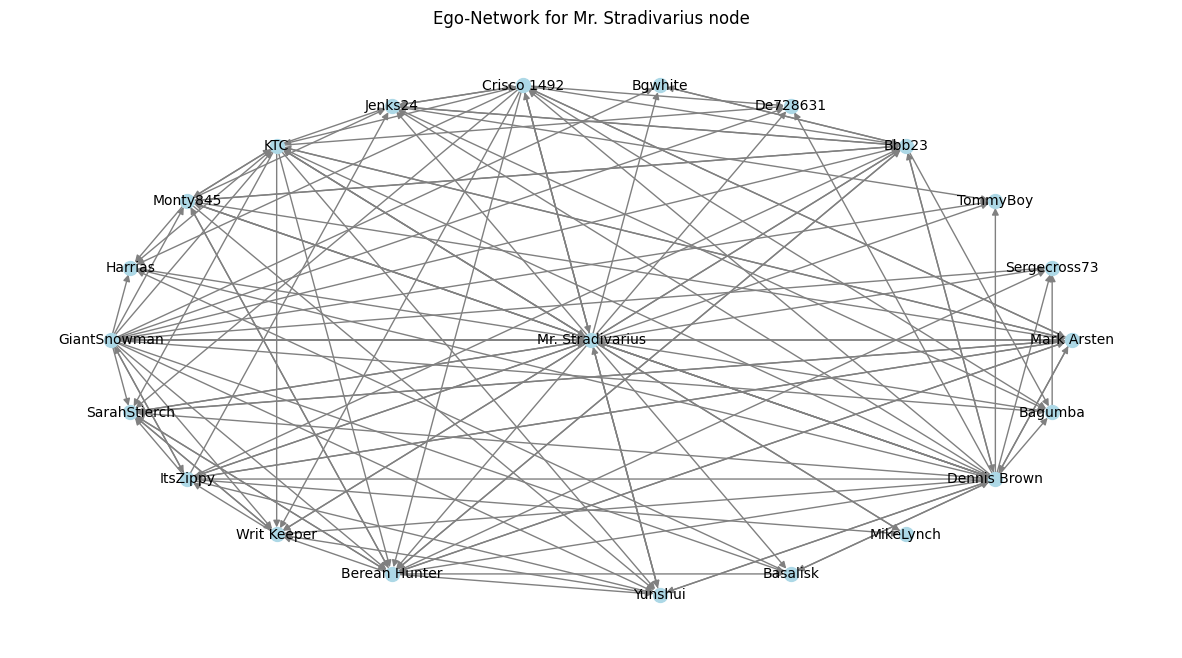

In [38]:
node_of_interest = 'Mr. Stradivarius'
ego_network = nx.ego_graph(G, node_of_interest)
plt.figure(figsize=(15, 8))
pos = nx.circular_layout(ego_network, scale=1, center=(0, 0))
pos[node_of_interest] = (0, 0)
nx.draw_networkx(ego_network, pos=pos, with_labels=True, node_color='lightblue', node_size=100, font_size=10, edge_color='grey')
plt.title("Ego-Network for Mr. Stradivarius node")
plt.axis('off')
plt.show()

In the graph, we see a node 'Mr. Stradivarius' in the center and 21 other nodes for which he gave his vote

We can look at the node with the highest closeness centrality:

In [39]:
dataframe.sort_values(by='Closeness Centrality Rank', ascending=True).head(5)

,Node,Node Degree,Betweenness Centrality,Closeness Centrality,In Degree Centrality,Out Degree Centrality,In Degree Centrality Rank,Out Degree Centrality Rank,Betweenness Centrality Rank,Closeness Centrality Rank
221,SarahStierch,221,0.002927,0.474884,0.285151,0.005256,1.0,203.0,7.0,1.0
86,Berean Hunter,168,0.002031,0.463230,0.210250,0.010512,2.0,102.0,11.0,2.0
539,Writ Keeper,116,0.001841,0.444810,0.149803,0.002628,10.0,315.0,12.0,3.0
264,Mark Arsten,129,0.003023,0.435196,0.160315,0.009198,8.0,120.0,6.0,4.0
65,Bbb23,143,0.002649,0.426892,0.177398,0.010512,3.0,102.0,8.0,5.0


A Closeness Centrality of 0.475 for the node 'SarahStierch' suggests that this node has a relatively high degree of closeness to other nodes in the network. Closeness centrality measures how close a node is, on average, to all other nodes in the network. It quantifies the efficiency of information or resource flow from a node to other nodes.

A higher closeness centrality indicates that the node 'SarahStierch' is more central in terms of its proximity to other nodes. It implies that 'SarahStierch' can quickly interact or exchange information with other nodes in the network, as it requires fewer steps or hops to reach most other nodes.

In practical terms, a node with a high closeness centrality, may has advantages such as being able to access and disseminate information more efficiently, exert influence over the network, or serve as a bridge between different groups or communities within the network.

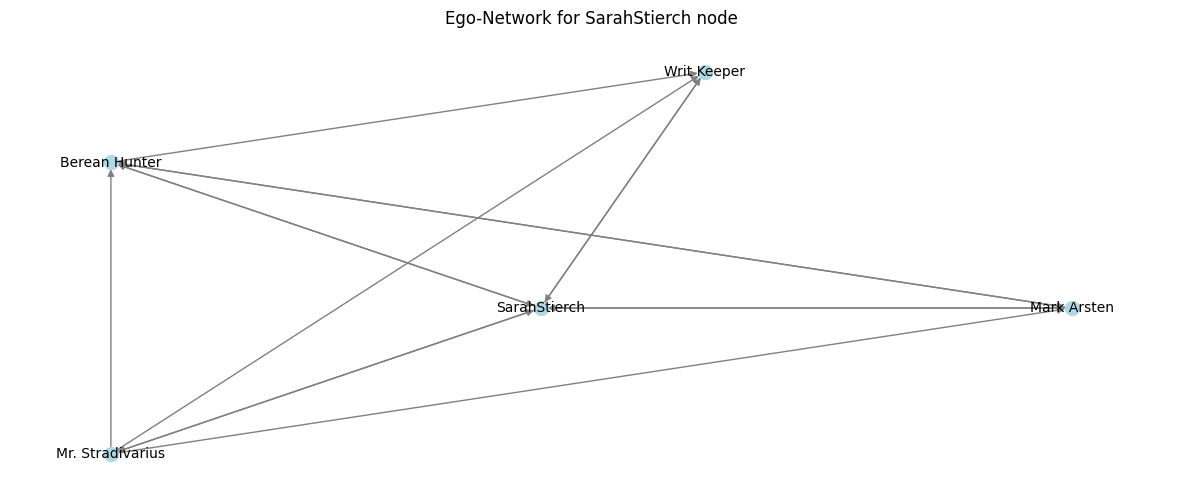

In [40]:
node_of_interest = 'SarahStierch'
ego_network = nx.ego_graph(G, node_of_interest)
plt.figure(figsize=(15,6))
pos = nx.circular_layout(ego_network, scale=1, center=(0, 0))
pos[node_of_interest] = (0, 0)
nx.draw_networkx(ego_network, pos=pos, with_labels=True, node_color='lightblue', node_size=100, font_size=10, edge_color='grey')
plt.title("Ego-Network for SarahStierch node")
plt.axis('off')
plt.show()

'SarahStierch' has very high (1) rank of In Degree Centrality and very low (203) rank of Out Degree Centrality. That means that the node received a lot of votes but didn't vote itself.

From computing several useful centrality measures we can make some conclusions:
* Node 23 (Mr. Stradivarius) has the highest Betweenness Centrality (0.005860), indicating that this node plays a critical role in controlling the flow of information or resources between other nodes in the network.
* Node 221 (SarahStierch) has the highest Closeness Centrality (0.474884), indicating that this node is closely connected to other nodes in the network and has efficient access to information from other nodes or the ability to disseminate information to them.
* In general, we can observe that the nodes that received the most votes (high in-degree) have the highest Closeness Centrality
* Nodes with a high degree of centrality are those who received positive votes (high in-degree), got the role of admins and started themselves and managed to vote for other participants

## Community Discovery

1) Greedy modularity optimization algorithm

The greedy modularity optimization algorithm aims to partition a network into communities based on the concept of modularity. Modularity is a measure that quantifies the quality of a partition of a network into communities. It compares the number of within-community edges to the expected number of such edges in a random network with the same degree distribution. A higher modularity value indicates a better community structure.

The greedy modularity optimization algorithm starts with each node in its own community and iteratively merges communities to increase the overall modularity of the partition. At each step, the algorithm considers merging two communities that would result in the largest increase in modularity. This process continues until no further improvement in modularity is possible.

The algorithm's greedy nature means that it makes locally optimal decisions at each step, aiming to maximize modularity. However, it does not guarantee finding the globally optimal community structure, and the quality of the detected communities depends on the initial network structure and the order in which communities are merged.

In [41]:
modularity_communities = nxc.greedy_modularity_communities(G)
print("Number of communities:", len(modularity_communities))

Number of communities: 5


We can calculate the size, the density and the average centrality within each community:

In [42]:
mod_comm = []
for i, community in enumerate(modularity_communities):
    community_size = len(community)
    community_subgraph = G.subgraph(community)
    community_density = nx.density(community_subgraph)
    community_centralities = nx.betweenness_centrality(community_subgraph).values()
    community_average_centrality = sum(community_centralities) / len(community_centralities)
    mod_comm.append({
        'Community': i+1,
        'Size': round(community_size,5),
        'Density': round(community_density,5),
        'Average Centrality': round(community_average_centrality,5)})
mod_comm = pd.DataFrame(mod_comm)
mod_comm

,Community,Size,Density,Average Centrality
0,1,215,0.00895,0.00007
1,2,184,0.01417,0.00017
2,3,170,0.01323,0.00018
3,4,165,0.01038,0.00016
4,5,28,0.03571,0.00000


Compute the modularity:

In [43]:
Q_modularity = modularity(G, [set(nodes) for nodes in modularity_communities])
print("Modularity of the Modularity Communities Partition:", Q_modularity)

Modularity of the Modularity Communities Partition: 0.299619570520409


Using the greedy modularity optimization algorithm the network has been partitioned into 5 communities. The modularity of the modularity communities partition is 0.2996. Modularity is a measure that quantifies the degree to which the network can be divided into distinct communities. A higher modularity value suggests a better division of the network into cohesive communities. Since modularity ranges from -1 to 1, with higher values indicating better community structure, a modularity value of 0.2996 suggests a moderate level of community structure in the network. It indicates that the partitioning into communities has captured some level of clustering and separation among nodes, but there is still room for improvement.

Plot the graph with different colors for each community:

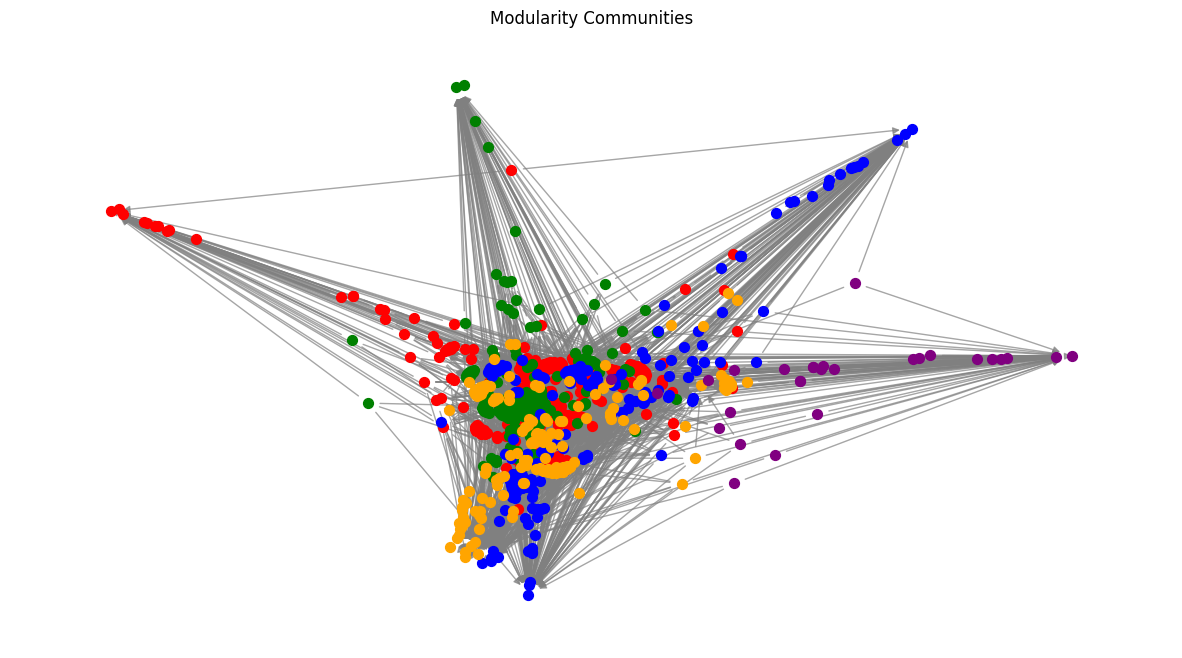

In [44]:
modularity_communities = list(modularity_communities)

node_community_map = {} # Create a dictionary to map each node to its community index
for i, community in enumerate(modularity_communities):
    for node in community:
        node_community_map[node] = i

community_colors = ['red', 'green', 'blue', 'orange', 'purple'][:len(modularity_communities)]

modularity_communities = [set(community) for community in modularity_communities]# Convert frozenset to set

plt.figure(figsize=(15, 8))
pos = nx.spring_layout(G, seed=1)
for community in modularity_communities:
    nx.draw_networkx_nodes(G, pos=pos, nodelist=list(community), node_color=community_colors[node_community_map[list(community)[0]]], node_size=50)
nx.draw_networkx_edges(G, pos=pos, edge_color='grey', alpha=0.7)
plt.title("Modularity Communities")
plt.axis('off')
plt.show()

The following conclusions can be drawn:
* The algorithm has identified 5 distinct communities within the network.
* The size of each community varies, ranging from 1 to 215 nodes.
* The density of a community represents the proportion of actual edges present compared to the total number of possible edges within that community. The reported densities range from 0.00895 to 0.03571. Higher density values indicate a more interconnected community, suggesting stronger ties between nodes within the community.
* The average centrality of a community provides insights into the centrality measures, averaged across all nodes within the community. The average centrality values reported are relatively small, ranging from 0.00007 to 0.00018. This suggests that, on average, the nodes in the communities do not exhibit particularly high centrality within the overall network.

2) Louvain Community Detection Algorithm

Louvain Community Detection Algorithm is a simple method to extract the community structure of a network. This is a heuristic method based on modularity optimization. The algorithm works in 2 steps. On the first step it assigns every node to be in its own community and then for each node it tries to find the maximum positive modularity gain by moving each node to all of its neighbor communities. If no positive gain is achieved the node remains in its original community.

In [45]:
louvain_communities = nxc.louvain_communities(G, seed=42)
print("Number of communities:", len(louvain_communities))

Number of communities: 23


In [46]:
Q_louvain = modularity(G, [set(nodes) for nodes in louvain_communities])
print("Modularity of the Louvain Communities Partition:", Q_louvain)

Modularity of the Louvain Communities Partition: 0.24374250923745647


In [47]:
lou_comm = []
for i, community in enumerate(louvain_communities):
    community_size = len(community)
    community_subgraph = G.subgraph(community)
    community_density = nx.density(community_subgraph)
    community_centralities = nx.betweenness_centrality(community_subgraph).values()
    community_average_centrality = sum(community_centralities) / len(community_centralities)
    lou_comm.append({
        'Community': i+1,
        'Size': round(community_size,5),
        'Density': round(community_density,5),
        'Average Centrality': round(community_average_centrality,5)})
lou_comm = pd.DataFrame(lou_comm)
lou_comm

,Community,Size,Density,Average Centrality
0,1,20,0.05000,0.00000
1,2,25,0.04000,0.00000
2,3,22,0.04545,0.00000
3,4,18,0.05556,0.00000
4,5,37,0.02703,0.00000
5,6,60,0.02768,0.00010
6,7,35,0.02857,0.00000
7,8,38,0.03129,0.00059
8,9,46,0.03865,0.00000
9,10,35,0.02857,0.00000


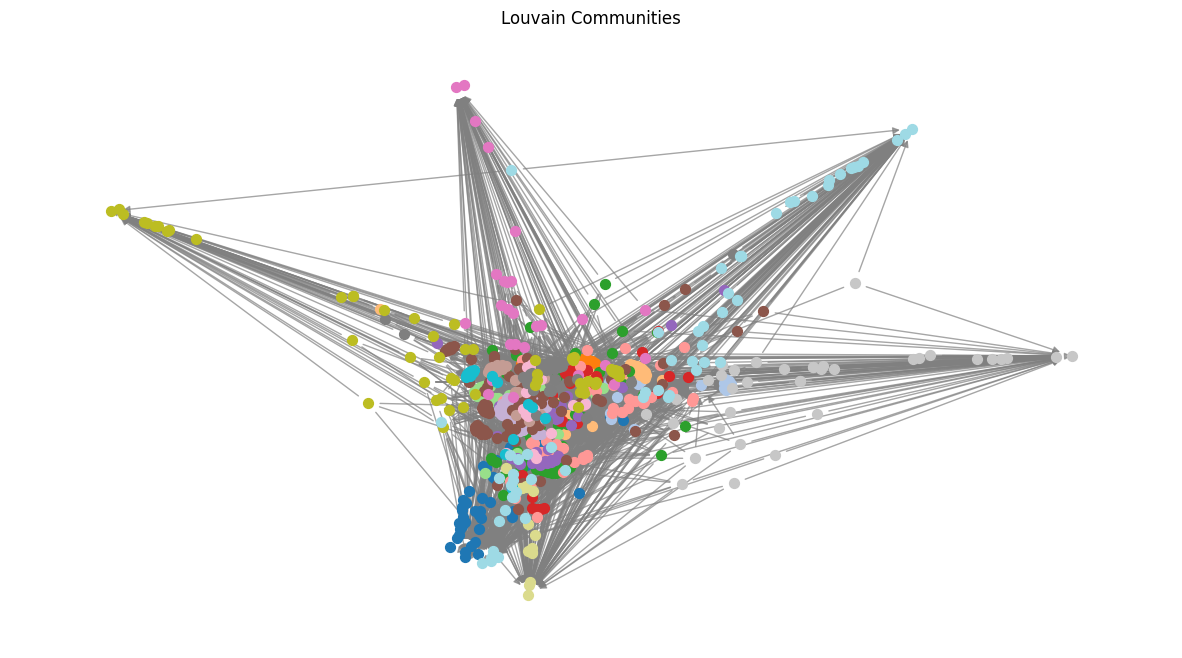

In [48]:
warnings.filterwarnings('ignore') #Ignoring warnings
louvain_communities = list(louvain_communities)

node_community_map = {}  # Create a dictionary to map each node to its community index
for i, community in enumerate(louvain_communities):
    for node in community:
        node_community_map[node] = i

num_communities = len(louvain_communities)
colors = cm.get_cmap('tab20', num_communities)#color for each community

louvain_communities = [set(community) for community in louvain_communities]  #frozenset -> set

plt.figure(figsize=(15, 8))
pos = nx.spring_layout(G, seed=1)
for community in louvain_communities:
    community_index = node_community_map[list(community)[0]]
    color = colors(community_index % num_communities)
    nx.draw_networkx_nodes(G, pos=pos, nodelist=list(community), node_color=color, node_size=50)
nx.draw_networkx_edges(G, pos=pos, edge_color='grey', alpha=0.7)
plt.title("Louvain Communities")
plt.axis('off')
plt.show()
warnings.filterwarnings('default') #Returning warnings

The community graph is very messy, hard to identify functional groups. We can try to plot different communities into separate plots:

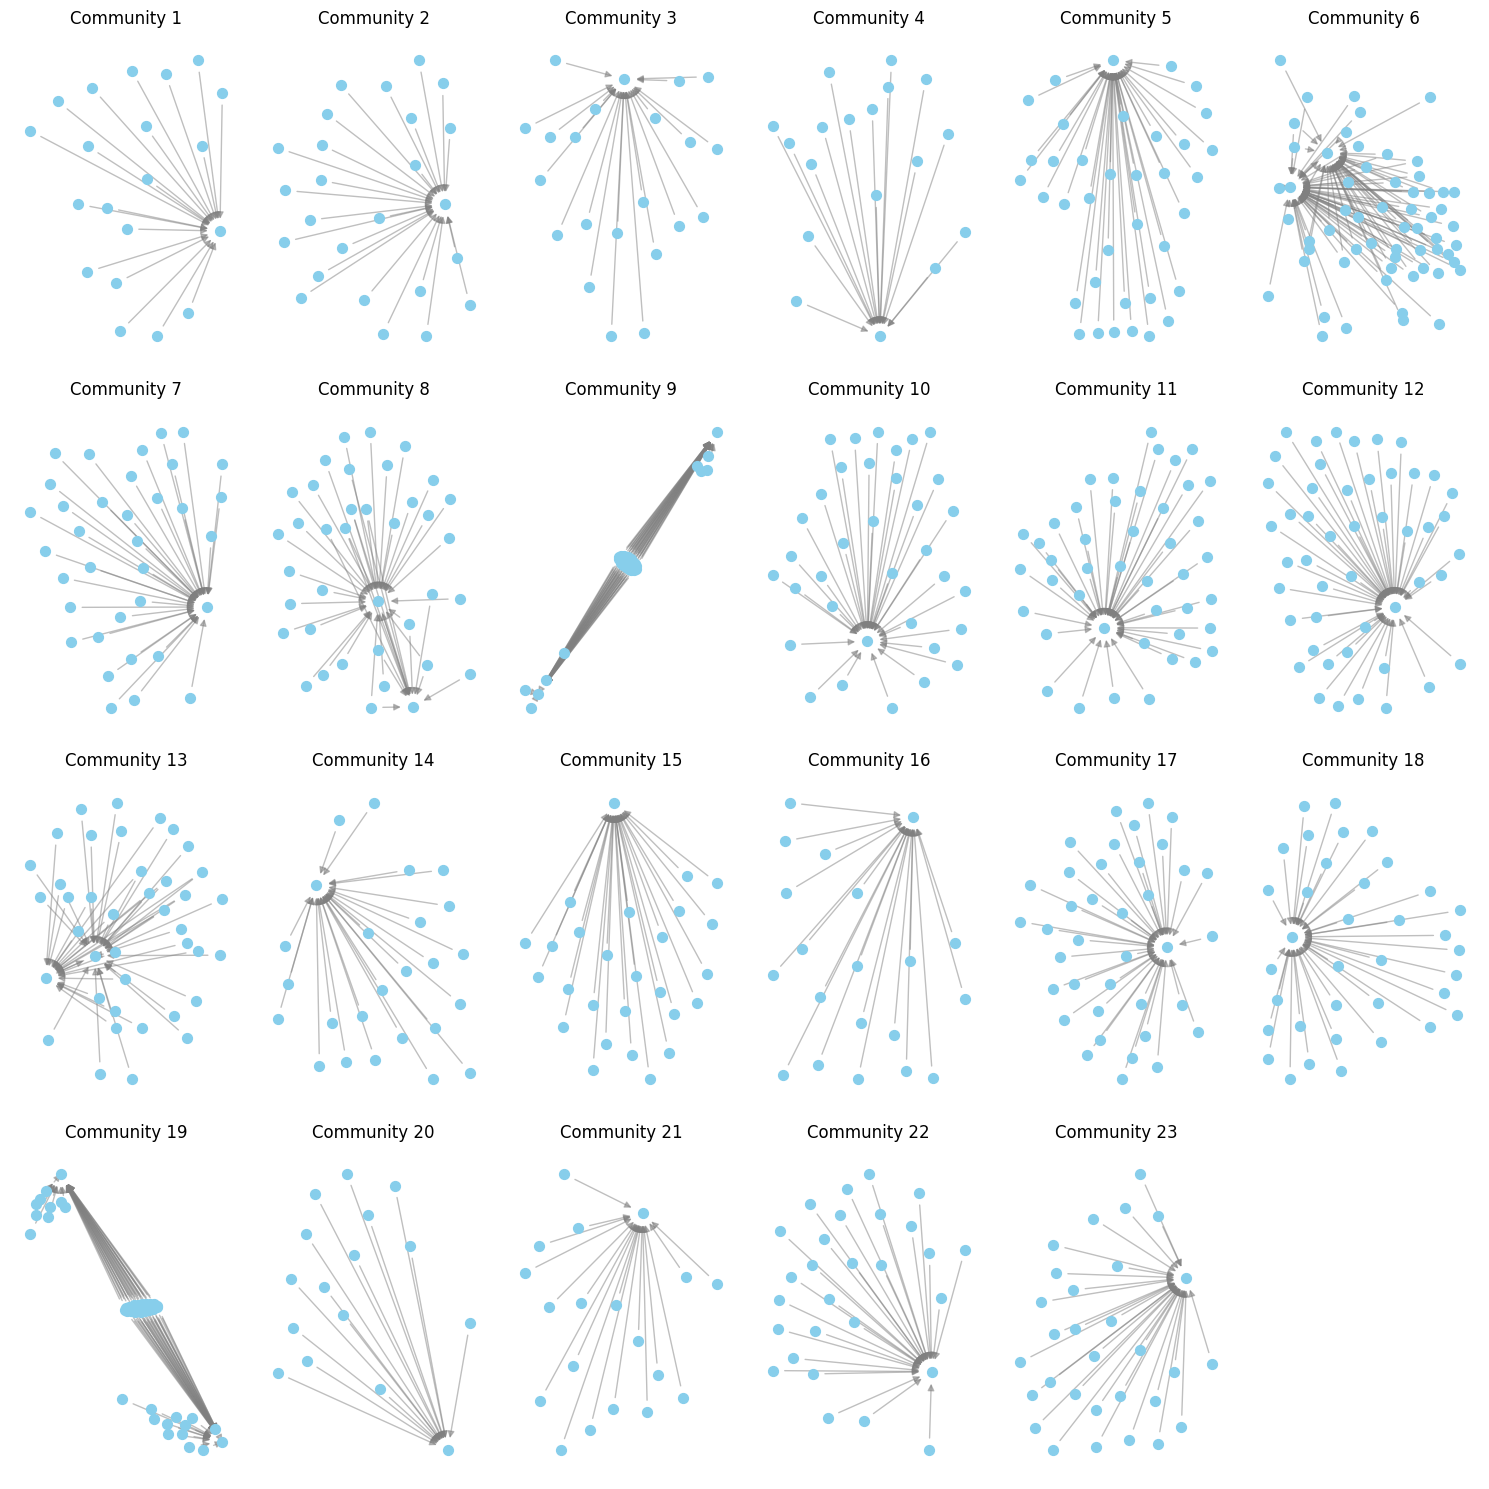

In [49]:
num_communities = len(louvain_communities)

# Set the subplot layout
num_rows = int(num_communities**0.5)
num_cols = (num_communities + num_rows - 1) // num_rows

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))
axes = axes.flatten()

# Plot each community on a separate subplot
for i, community in enumerate(louvain_communities):
    subgraph = G.subgraph(community)
    pos = nx.spring_layout(subgraph)
    ax = axes[i]
    ax.set_title("Community {}".format(i+1))
    ax.axis("off")
    nx.draw_networkx_nodes(subgraph, pos, ax=ax, node_size=50, node_color='skyblue')
    nx.draw_networkx_edges(subgraph, pos, ax=ax, alpha=0.5, edge_color='gray')

# Remove empty subplots if the number of communities is not a perfect square
if num_communities < num_rows * num_cols:
    for i in range(num_communities, num_rows * num_cols):
        fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

This graph clearly shows that the communities are formed around the applicants.

The following conclusions can be drawn:
* The algorithm has identified 23 distinct communities within the network
* The size of each community varies, ranging from 16 to 60 nodes
* The density of a community represents the proportion of actual edges present compared to the total number of possible edges within that community. The reported densities range from 0.02083 to 0.06250. These values indicate that the communities have varying levels of interconnectivity, with some communities having denser connections than others
* The average centrality of a community provides insights into the centrality measures, averaged across all nodes within the community. The average centrality values reported for all communities are 0, indicating that, the nodes in the communities do not exhibit centrality within the overall network.

Comparison of modularity indicators shows that the greedy modularity optimization algorithm showed better results than louvain community detection algorithm

Also we can create 3d visualization of the communities:

In [50]:
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)
# Create example network
source = df_2012.Source
target = df_2012.Target
#weight = df_2012.Vote
# Convert to adjacency matrix
adjmat = vec2adjmat(source, target) #weight=weight)

# Initialize
d3 = d3graph(charge=450, collision=0.5)
# Proces adjmat
d3.graph(adjmat)

# Make changes in node properties
d3.set_node_properties(color='cluster')
# Plot
d3.show(show_slider=False)
warnings.filterwarnings('default', category=pd.errors.PerformanceWarning)

[d3graph] INFO> Set directed=True to see the markers!
[d3graph] INFO> Keep only edges with weight>0
[d3graph] INFO> Number of unique nodes: 761
[d3graph] INFO> Number of unique nodes: 761
C:\Users\lenovo\AppData\Local\Programs\Python\Python311\Lib\tempfile.py:895: ResourceWarning: Implicitly cleaning up <TemporaryDirectory 'C:\\Users\\lenovo\\AppData\\Local\\Temp\\tmp9s4qyf4r'>
  _warnings.warn(warn_message, ResourceWarning)
[d3graph] INFO> Slider range is set to [0, 1]
[d3graph] INFO> Write to path: [C:\Users\lenovo\AppData\Local\Temp\tmp9s4qyf4r\d3graph.html]
[d3graph] INFO> File already exists and will be overwritten: [C:\Users\lenovo\AppData\Local\Temp\tmp9s4qyf4r\d3graph.html]


## Node Roles

Node roles in network analysis refer to the identification and categorization of nodes based on their structural properties and their importance or influence within the network.

Computing rawComm for node roles assignment:

In [51]:
def rawComm(u, Graph, p=1, q=1):
    u_neighbours = set(Graph[u])
    
    def tau(v):
        return 1/(1 + p*len(u_neighbours.intersection(Graph[v])) + (1-q)*len(u_neighbours.difference(set(G[v]).union([v]))))

    contributions = [tau(v) for v in u_neighbours]
    return sum(contributions)

Text(0, 0.5, 'Degree')

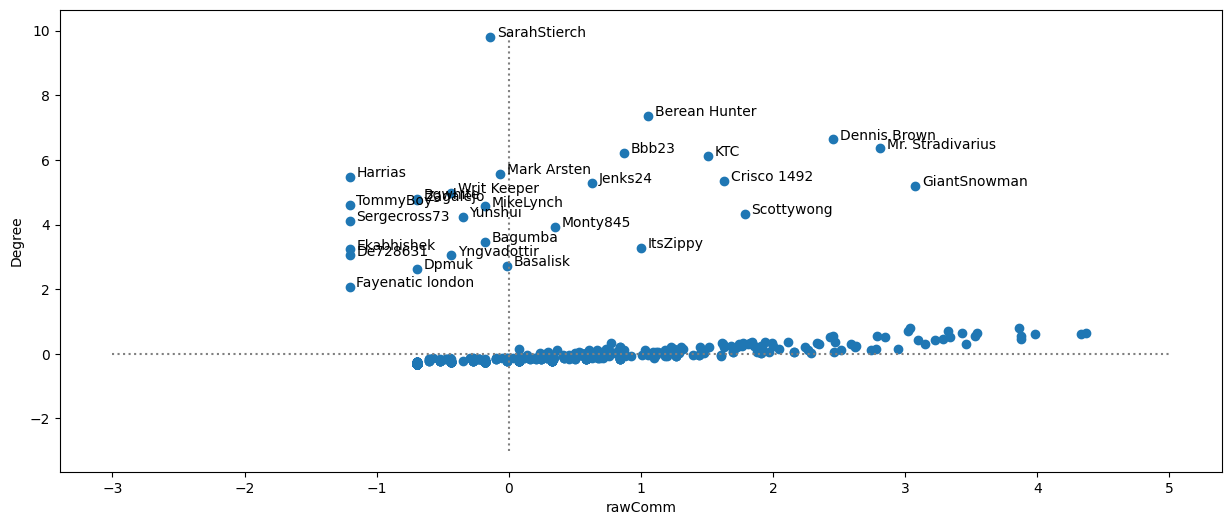

In [52]:
rawComms = [round(rawComm(node, G),2) for node in G.nodes]
degrees = [G.degree[node] for node in G.nodes]

df = pd.DataFrame(data={'rawComm':rawComms, 'Degree':degrees},index=G.nodes)
df.head()


scaler = StandardScaler()
df_sc = pd.DataFrame(
    scaler.fit_transform(df),
    columns=df.columns,
    index=df.index)
plt.figure(figsize=(15, 6))
plt.scatter(df_sc.rawComm, df_sc.Degree)
plt.plot([0,0], [-3,10], c='gray', linestyle='dotted')
plt.plot([-3,5], [0,0], c='gray', linestyle='dotted')

counter = Counter()
for i, row in df_sc.iterrows():
    coords = (row['rawComm'], row['Degree'])
    if row['Degree'] > 1: #annotation threshold
        plt.annotate(i, (row['rawComm'] + counter[coords]/8 + 0.05, row['Degree']))
        counter[coords]+=1
plt.xlabel('rawComm')
plt.ylabel('Degree')

* Left bottom corner - Loners: low degree, low community score
* Left upper corner - Big Fish: high degree, low community score – are well connected within one of few small communities
* Right bottom corner - Bridge: low degree, high community score – bridge communities but are generally not too well connected within them
* Right upper corner - Ambassador: high degree, high community score – provide many connections to many communities

Node roles help us understand the different functions or behaviors exhibited by nodes in a network.
* In the case of our dataset, the Big Fish nodes are newly elected administrators. Many participants voted for them, but they themselves are not yet active in giving votes
* Bridge nodes are active administrators who vote for new members. They associate new nodes with existing ones 
* There are not too much Loner nodes. This means that a small fraction of active admins are not very active in voting
* And the Ambassadors - newly elected admins who have begun casting their votes for new challengers

In [53]:
end_time = time.time()

In [54]:
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

Execution time: 92.34861612319946 seconds


## Conclusions and Future Work

We conducted the analysis of the Wikipedia requests for adminship (RfA) data using network analysis techniques. Here is a summary and interpretation of the achieved results:

1) Graph Properties: The computed graph properties have revealed the overall structure and characteristics of the voting network:

* Graph Size: The graph consists of 762 nodes (representing users) and 2948 edges (representing the relationships between users through voting interactions).

* The graph is weakly connected, meaning there is a directed path from any node to any other node when considering the direction of edges. However, it does not necessarily mean that there is a direct path in both directions between every pair of nodes. This indicates that information and influence can flow across the graph, albeit potentially through indirect paths.

* The largest strongly connected component in the graph consists of 20 nodes. A strongly connected component is a subset of nodes in a directed graph where there is a directed path from any node to any other node within the subset. The presence of a large strongly connected component suggests a cohesive subgroup within the graph where users have mutually influenced each other's voting decisions.

* The transitivity coefficient of the graph is 0.255, indicating a moderate level of clustering or interconnectedness within the graph. This suggests that users in the graph tend to form clusters or groups, where if user A is connected to user B and user B is connected to user C, there is a higher likelihood that user A is also connected to user C. This level of clustering implies the presence of certain communities or shared interests among users.

* The average clustering coefficient of the graph is 0.167, which is relatively low. This suggests that, on average, the nodes in the graph have a lower tendency to form clusters or triangles compared to a highly clustered graph. It indicates that while there are some localized clusters or groups, the overall level of clustering is not particularly strong.

* The reciprocity of the graph is 0.021, indicating a low reciprocity. Reciprocity measures the tendency for bidirectional connections in the graph. A low reciprocity suggests that when a user is connected to another user through a voting interaction, the reverse connection (user B voting for user A) is less likely to exist. This implies that there might be variations in the level of mutual support or agreement among users in the voting process.


2) Centrality Measures: The calculated centrality measures, including degree centrality, betweenness centrality, and eigenvector centrality, have identified influential users within the voting network. 

* Node 23 (Mr. Stradivarius) has the highest Betweenness Centrality (0.005860). This indicates that this node plays a critical role in controlling the flow of information or resources between other nodes in the network. Mr. Stradivarius acts as a bridge, influencing the interactions and decision-making processes among other users in the RfA network. This user received votes during the voting process and also began to give votes for over users

* Node 221 (SarahStierch) has the highest Closeness Centrality (0.474884). This implies that SarahStierch is closely connected to other nodes in the network and has efficient access to information from other nodes or the ability to disseminate information to them. SarahStierch is one who received most of the votes. SarahStierch is well-positioned to quickly receive and transmit information within the RfA network due to her proximity to other users.

* It is observed that nodes with a higher number of votes (high in-degree) tend to have higher Closeness Centrality. This suggests that users who received more votes and gained support from the community also tend to have better access to information and influence within the network. The high in-degree nodes have established strong connections and are more central in terms of information flow and decision-making.

*  Nodes with a high degree of centrality, specifically those who received positive votes (high in-degree), have successfully obtained the role of administrators and actively participated in voting for other participants. This indicates that users who were highly regarded by the community, based on their vote count, not only became administrators but also continued to engage in the voting process, potentially shaping the composition of the administrator community.

* Comparing nodes based on centrality measures has allowed the identification of administrators who have actively participated in the voting process and have shown a strong commitment to data quality management. These individuals have played a vital role in ensuring the reliability and accuracy of the information used for training neural network models.

3) Community Detection: The application of community detection algorithms has uncovered distinct communities within the network. Analyzing these communities, including their size, density, and average centrality measures, has provided an understanding of the voting network's composition. Most of the communities are organized around applicants.

4) Node Roles provide insights into the different functions and behaviors exhibited by nodes:

* Big Fish Nodes (Newly Elected Administrators): These nodes are newly elected administrators who have received a significant number of votes from the community. However, they themselves are not yet active in giving votes. This suggests that they are in the early stages of their administrative role and are still transitioning into their responsibilities.

* Bridge Nodes (Active Administrators): These nodes are active administrators who play a crucial role in the voting process. They vote for new members and serve as connectors or bridges between existing administrators and the newly elected ones. Their presence helps integrate new nodes into the network and facilitate the continuation of the voting process.

* Loner Nodes: The presence of a small fraction of Loner nodes indicates that some active administrators are not very active in voting. These nodes have relatively fewer connections or engagements within the network. They may have a limited role in the voting process or contribute less frequently compared to other administrators.

* Ambassadors (Newly Elected Administrators): These nodes represent newly elected administrators who have started casting their votes for new challengers. They have transitioned into their role as administrators and actively participate in the voting process to shape the composition of the administrator community.


Comparison to the Original Plan:

The achieved results align with the original plan. The data collection and preprocessing, graph construction, and subsequent graph analysis, centrality measures, and community detection have been successfully executed. The outcomes have provided insights into the network structure, influential users, and community characteristics as initially intended.

Generated Value:

The analysis of the Wikipedia RfA voting network has created value for the organization in multiple ways:

Improved Administrator Selection: By understanding the dynamics of the voting process and identifying influential users and key contributors, the organization can refine the selection criteria for administrators responsible for data quality management. Incorporating these insights into the selection process will enhance the trustworthiness and reliability of the administrators, thereby improving data quality.

Reliable Training Data: By incorporating high-quality training data from Wikipedia, the organization can enhance the reliability and accuracy of its neural network models. The insights gained from the analysis will help identify users who have actively contributed to data quality management, ensuring that the training data used for AI models is more robust and trustworthy.

The election process is not directly regulated by Wikipedia. However, in order to engage and maintain interest in participating in elections would be right to promote community engagement in the voting process:
* Encourage active participation and discussion among community members regarding the suitability of candidates. 
* Encourage active participants to share their best practices and strategies with other users 
* Foster collaboration and engagement with influential users identified through centrality measures. 

Ideas for Future Work:

* Temporal Analysis. We analyzed data for 2012 only. Extend the analysis to incorporate temporal aspects by considering the evolution of the voting network over time. Analyze how user roles, influential users, and community structures change over different periods.
* Sentiment Analysis. The data includes comments left by the voters when they cast their vote. For the purposes of this analysis, we did not conduct any experiments with this text data. Integrate sentiment analysis techniques to understand the sentiment associated with user interactions and voting decisions. This can provide insights into the emotional dynamics within the community and their potential impact on decision-making.
* User Contribution Analysis. Explore user contribution patterns and identify users who consistently contribute high-quality content.